***Copyright 2020 The TensorFlow Authors.***

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lattice を使った倫理のための形状制約

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/shape_constraints_for_ethics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/lattice/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## 概要

このチュートリアルでは、TensorFlow Lattice（TFL）ライブラリを使用して、モデルが*責任を持って*振る舞い、ある*倫理的*または*平等な*想定に反しないようにトレーニングします。具体的には、単調性制約を使用して、特定の属性が*不平等にペナルティ付け*されないようにすることに焦点を当てます。このチュートリアルには、Serena Wang と Maya Gupta が執筆し、[AISTATS 2020](https://www.aistats.org/) で発表された論文「[*Deontological Ethics By Monotonicity Shape Constraints*](https://arxiv.org/abs/2001.11990)」の実験の実演が含まれます。

パブリックデータセットで TFL 缶詰 Estimator を使用しますが、このチュートリアルに記載されている内容は、TFL Keras レイヤーから構築されたモデルでも実行できます。

続行する前に、ランタイムに必要なすべてのパッケージがインストールされていることを確認してください（以下のコードセルでインポートされるとおりに行います）。

## セットアップ

TF Lattice パッケージをインストールします。

In [2]:
#@test {"skip": true}
!pip install -q tensorflow-lattice seaborn

必要なパッケージをインポートします。

In [3]:
import tensorflow as tf

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

このチュートリアルで使用されるデフォルト値です。

In [4]:
# List of learning rate hyperparameters to try.
# For a longer list of reasonable hyperparameters, try [0.001, 0.01, 0.1].
LEARNING_RATES = [0.01]
# Default number of training epochs and batch sizes.
NUM_EPOCHS = 1000
BATCH_SIZE = 1000
# Directory containing dataset files.
DATA_DIR = 'https://raw.githubusercontent.com/serenalwang/shape_constraints_for_ethics/master'

# 事例 1: 法科大学院への進学適正

このチュートリアルの前半では、法科大学院入学審議会（LSAC）の Law School Admissions データセットを使った事例を考察します。学生の LSAT スコアと学部課程の GPA という 2 つの特徴量を使用して、学生が司法試験に合格するかどうかを予測するための分類器をトレーニングします。

分類器のスコアによって法科大学院への進学適正または奨学金が誘導されると仮定しましょう。メリットに基づく社会規範に従うと、GPA と LSAT スコアがより高い学生が分類器からより高いスコアを得ることが期待されますが、 モデルがたやすくこういった直感的な規範を違反し、より高い GPA と LSAT スコアに対して学生にペナルティが科されることがあることが観察されます。

この*不平等なペナリゼーション*問題を解決するために、単調性制約を課すことで、モデルがより高い GPA と LSAT スコアにペナルティを決して科すことなく、すべて平等に審査するようにすることができます。このチュートリアルでは、TFL を使って単調性制約を課す方法を説明します。

## 法科大学院データを読み込む

In [5]:
# Load data file.
law_file_name = 'lsac.csv'
law_file_path = os.path.join(DATA_DIR, law_file_name)
raw_law_df = pd.read_csv(law_file_path, delimiter=',')

データセットを前処理します。

In [6]:
# Define label column name.
LAW_LABEL = 'pass_bar'

In [7]:
def preprocess_law_data(input_df):
  # Drop rows with where the label or features of interest are missing.
  output_df = input_df[~input_df[LAW_LABEL].isna() & ~input_df['ugpa'].isna() &
                       (input_df['ugpa'] > 0) & ~input_df['lsat'].isna()]
  return output_df


law_df = preprocess_law_data(raw_law_df)

### データをトレーニング/検証/テストセットに分割する

In [8]:
def split_dataset(input_df, random_state=888):
  """Splits an input dataset into train, val, and test sets."""
  train_df, test_val_df = train_test_split(
      input_df, test_size=0.3, random_state=random_state)
  val_df, test_df = train_test_split(
      test_val_df, test_size=0.66, random_state=random_state)
  return train_df, val_df, test_df


law_train_df, law_val_df, law_test_df = split_dataset(law_df)

### データの分布を視覚化する

まず、データの分布を視覚化します。司法試験に合格したすべての学生と合格しなかった学生の GPA と LSAT スコアを描画します。

In [9]:
def plot_dataset_contour(input_df, title):
  plt.rcParams['font.family'] = ['serif']
  g = sns.jointplot(
      x='ugpa',
      y='lsat',
      data=input_df,
      kind='kde',
      xlim=[1.4, 4],
      ylim=[0, 50])
  g.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
  g.ax_joint.collections[0].set_alpha(0)
  g.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
  g.fig.suptitle(title, fontsize=14)
  # Adust plot so that the title fits.
  plt.subplots_adjust(top=0.9)
  plt.show()

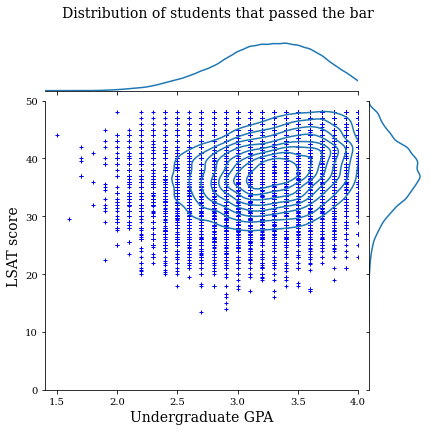

In [10]:
law_df_pos = law_df[law_df[LAW_LABEL] == 1]
plot_dataset_contour(
    law_df_pos, title='Distribution of students that passed the bar')

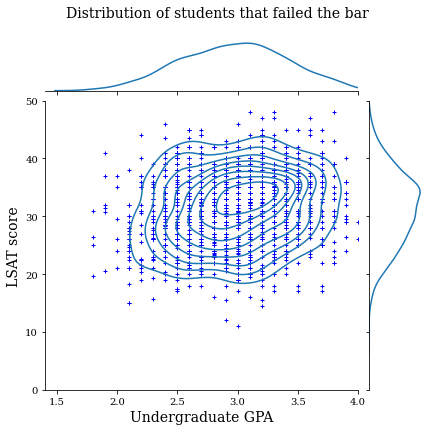

In [11]:
law_df_neg = law_df[law_df[LAW_LABEL] == 0]
plot_dataset_contour(
    law_df_neg, title='Distribution of students that failed the bar')

## 司法試験通過を予測する較正済み線形モデルをトレーニングする

次に、学生が司法試験に合格するかどうかを予測するために、TFL の*較正済み線形モデル*をトレーニングします。LSAT スコアと学部課程の GPA を 2 つの特徴量として使用し、学生が司法試験に合格するかどうかをトレーニングラベルとします。

まず制約を使用せずに、較正済み線形モデルをトレーニングします。次に、単調性制約を使用して較正済み線形モデルをトレーニングし、モデルの出力と精度に生じる違いを観察します。

### TFL 較正済み線形 Estimator をトレーニングするためのヘルパー関数

これらは、この法科大学院の事例と以下の債務不履行の事例に使用されます。

In [12]:
def train_tfl_estimator(train_df, monotonicity, learning_rate, num_epochs,
                        batch_size, get_input_fn,
                        get_feature_columns_and_configs):
  """Trains a TFL calibrated linear estimator.

  Args:
    train_df: pandas dataframe containing training data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rate: learning rate of Adam optimizer for gradient descent.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    estimator: a trained TFL calibrated linear estimator.

  """
  feature_columns, feature_configs = get_feature_columns_and_configs(
      monotonicity)

  model_config = tfl.configs.CalibratedLinearConfig(
      feature_configs=feature_configs, use_bias=False)

  estimator = tfl.estimators.CannedClassifier(
      feature_columns=feature_columns,
      model_config=model_config,
      feature_analysis_input_fn=get_input_fn(input_df=train_df, num_epochs=1),
      optimizer=tf.keras.optimizers.Adam(learning_rate))

  estimator.train(
      input_fn=get_input_fn(
          input_df=train_df, num_epochs=num_epochs, batch_size=batch_size))
  return estimator


def optimize_learning_rates(
    train_df,
    val_df,
    test_df,
    monotonicity,
    learning_rates,
    num_epochs,
    batch_size,
    get_input_fn,
    get_feature_columns_and_configs,
):
  """Optimizes learning rates for TFL estimators.

  Args:
    train_df: pandas dataframe containing training data.
    val_df: pandas dataframe containing validation data.
    test_df: pandas dataframe containing test data.
    monotonicity: if 0, then no monotonicity constraints. If 1, then all
      features are constrained to be monotonically increasing.
    learning_rates: list of learning rates to try.
    num_epochs: number of training epochs.
    batch_size: batch size for each epoch. None means the batch size is the full
      dataset size.
    get_input_fn: function that returns the input_fn for a TF estimator.
    get_feature_columns_and_configs: function that returns TFL feature columns
      and configs.

  Returns:
    A single TFL estimator that achieved the best validation accuracy.
  """
  estimators = []
  train_accuracies = []
  val_accuracies = []
  test_accuracies = []
  for lr in learning_rates:
    estimator = train_tfl_estimator(
        train_df=train_df,
        monotonicity=monotonicity,
        learning_rate=lr,
        num_epochs=num_epochs,
        batch_size=batch_size,
        get_input_fn=get_input_fn,
        get_feature_columns_and_configs=get_feature_columns_and_configs)
    estimators.append(estimator)
    train_acc = estimator.evaluate(
        input_fn=get_input_fn(train_df, num_epochs=1))['accuracy']
    val_acc = estimator.evaluate(
        input_fn=get_input_fn(val_df, num_epochs=1))['accuracy']
    test_acc = estimator.evaluate(
        input_fn=get_input_fn(test_df, num_epochs=1))['accuracy']
    print('accuracies for learning rate %f: train: %f, val: %f, test: %f' %
          (lr, train_acc, val_acc, test_acc))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
  max_index = val_accuracies.index(max(val_accuracies))
  return estimators[max_index]

### 法科大学院データセットの特徴量を構成するためのヘルパー関数

これらのヘルパー関数は法科大学院の事例に特化した関数です。

In [13]:
def get_input_fn_law(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for law school models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['ugpa', 'lsat']],
      y=input_df['pass_bar'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_law(monotonicity):
  """Gets TFL feature configs for law school models."""
  feature_columns = [
      tf.feature_column.numeric_column('ugpa'),
      tf.feature_column.numeric_column('lsat'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='ugpa',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='lsat',
          lattice_size=2,
          pwl_calibration_num_keypoints=20,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### トレーニング済みモデルの出力を視覚化するためのヘルパー関数

In [14]:
def get_predicted_probabilities(estimator, input_df, get_input_fn):
  predictions = estimator.predict(
      input_fn=get_input_fn(input_df=input_df, num_epochs=1))
  return [prediction['probabilities'][1] for prediction in predictions]


def plot_model_contour(estimator, input_df, num_keypoints=20):
  x = np.linspace(min(input_df['ugpa']), max(input_df['ugpa']), num_keypoints)
  y = np.linspace(min(input_df['lsat']), max(input_df['lsat']), num_keypoints)

  x_grid, y_grid = np.meshgrid(x, y)

  positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
  plot_df = pd.DataFrame(positions.T, columns=['ugpa', 'lsat'])
  plot_df[LAW_LABEL] = np.ones(len(plot_df))
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=plot_df, get_input_fn=get_input_fn_law)
  grid_predictions = np.reshape(predictions, x_grid.shape)

  plt.rcParams['font.family'] = ['serif']
  plt.contour(
      x_grid,
      y_grid,
      grid_predictions,
      colors=('k',),
      levels=np.linspace(0, 1, 11))
  plt.contourf(
      x_grid,
      y_grid,
      grid_predictions,
      cmap=plt.cm.bone,
      levels=np.linspace(0, 1, 11))  # levels=np.linspace(0,1,8));
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Model score', fontsize=20)
  cbar.ax.tick_params(labelsize=20)

  plt.xlabel('Undergraduate GPA', fontsize=20)
  plt.ylabel('LSAT score', fontsize=20)

## 制約なし（非単調性）の較正済み線形モデルをトレーニングする

In [15]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949061, val: 0.945876, test: 0.951781


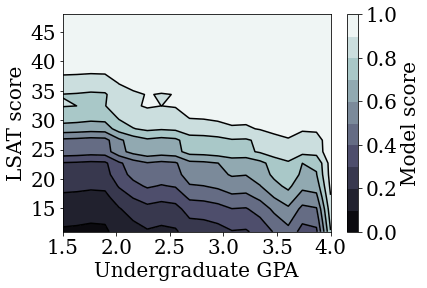

In [16]:
plot_model_contour(nomon_linear_estimator, input_df=law_df)

## 単調な較正済み線形モデルをトレーニングする

In [17]:
mon_linear_estimator = optimize_learning_rates(
    train_df=law_train_df,
    val_df=law_val_df,
    test_df=law_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_law,
    get_feature_columns_and_configs=get_feature_columns_and_configs_law)

accuracies for learning rate 0.010000: train: 0.949249, val: 0.945447, test: 0.951781


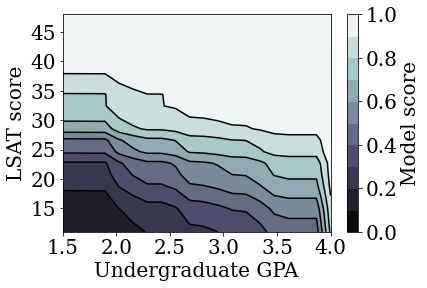

In [18]:
plot_model_contour(mon_linear_estimator, input_df=law_df)

## ほかの制約なしモデルをトレーニングする

TFL の較正済み線形モデルを、精度をそれほど大きく犠牲にすることなく LSAT スコアと GPA の両方で単調になるようにトレーニングできることを実演しました。

しかし、較正済み線形モデルは、ディープニューラルネットワーク（DNN）や勾配ブースティング木（GBT）などのほかの種類のモデルとどのように比較されるでしょうか。DNN と GBT は合理的に平等な出力を持つように見えるのでしょうか。この疑問への答えをえるために、制約なしの DNN と GBT をトレーニングすることにします。実際のところ、DNN と GBT は、LSAT スコアと学部課程の GPA の単調性を大きく侵害することが観察されるでしょう。

### 制約なしのディープニューラルネットワーク（DNN）モデルをトレーニングする

アーキテクチャは、高い検証精度を得られるように、最適化済みです。

In [19]:
feature_names = ['ugpa', 'lsat']

dnn_estimator = tf.estimator.DNNClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    hidden_units=[100, 100],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.008),
    activation_fn=tf.nn.relu)

dnn_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS))
dnn_train_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
dnn_val_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
dnn_test_acc = dnn_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for DNN: train: %f, val: %f, test: %f' %
      (dnn_train_acc, dnn_val_acc, dnn_test_acc))

accuracies for DNN: train: 0.949249, val: 0.947165, test: 0.951559


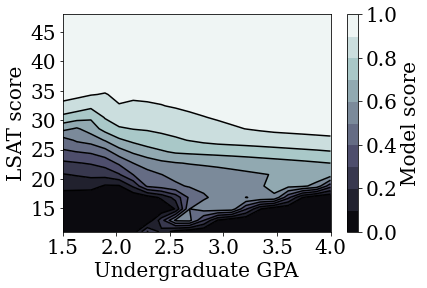

In [20]:
plot_model_contour(dnn_estimator, input_df=law_df)

### 制約なしの勾配ブースティング木（GBT）モデルをトレーニングする

木の構造は、高い検証精度を得られるように、最適化済みです。

In [21]:
tree_estimator = tf.estimator.BoostedTreesClassifier(
    feature_columns=[
        tf.feature_column.numeric_column(feature) for feature in feature_names
    ],
    n_batches_per_layer=2,
    n_trees=20,
    max_depth=4)

tree_estimator.train(
    input_fn=get_input_fn_law(
        law_train_df, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE))
tree_train_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_train_df, num_epochs=1))['accuracy']
tree_val_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_val_df, num_epochs=1))['accuracy']
tree_test_acc = tree_estimator.evaluate(
    input_fn=get_input_fn_law(law_test_df, num_epochs=1))['accuracy']
print('accuracies for GBT: train: %f, val: %f, test: %f' %
      (tree_train_acc, tree_val_acc, tree_test_acc))

accuracies for GBT: train: 0.949312, val: 0.945876, test: 0.951117


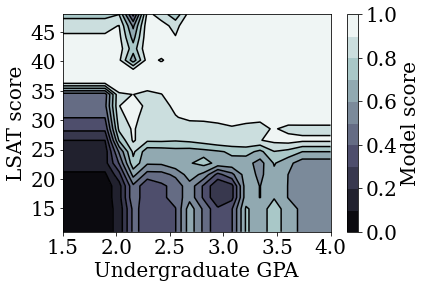

In [22]:
plot_model_contour(tree_estimator, input_df=law_df)

# 事例 2: 債務不履行

このチュートリアルで考察する 2 つ目の事例は、個人の債務不履行確率の予測です。UCI リポジトリの Default of Credit Card Clients データセットを使用します。このデータは、台湾の 30,000 人のクレジットカード利用者から集められたもので、ある期間に利用者が債務不履行となるかどうかを示すバイナリラベルが含まれます。特徴量には、2005 年 4 月から 9 月までの毎月の婚姻状況、性別、学歴、および利用者の既存の支払いの延滞期間が含まれます。

最初の事例と同様に、*不平等なペナリゼーション*を回避するために単調性制約を使用して説明します。モデルが利用者の信用スコアを決定するために使用される場合、ほかのすべてが同等である場合に請求書を早期に支払うことに対してペナルティが科されるのであれば、利用者は不平等だと感じることでしょう。そのため、モデルが早期払いにペナルティを科さないように、単調性制約を適用します。

## 債務不履行データを読み込む

In [23]:
# Load data file.
credit_file_name = 'credit_default.csv'
credit_file_path = os.path.join(DATA_DIR, credit_file_name)
credit_df = pd.read_csv(credit_file_path, delimiter=',')

In [24]:
# Define label column name.
CREDIT_LABEL = 'default'

### データをトレーニング/検証/テストセットに分割する

In [25]:
credit_train_df, credit_val_df, credit_test_df = split_dataset(credit_df)

### データの分布を視覚化する

まず、データの分布を視覚化します。さまざまな婚姻状況と支払い状況の利用者に確認される不履行率の平均と標準偏差を描画します。支払い状況は、利用者のローン返済の月数で表されます（2005 年 4 月時点）。

In [26]:
def get_agg_data(df, x_col, y_col, bins=11):
  xbins = pd.cut(df[x_col], bins=bins)
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
  return data


def plot_2d_means_credit(input_df, x_col, y_col, x_label, y_label):
  plt.rcParams['font.family'] = ['serif']
  _, ax = plt.subplots(nrows=1, ncols=1)
  plt.setp(ax.spines.values(), color='black', linewidth=1)
  ax.tick_params(
      direction='in', length=6, width=1, top=False, right=False, labelsize=18)
  df_single = get_agg_data(input_df[input_df['MARRIAGE'] == 1], x_col, y_col)
  df_married = get_agg_data(input_df[input_df['MARRIAGE'] == 2], x_col, y_col)
  ax.errorbar(
      df_single[(x_col, 'mean')],
      df_single[(y_col, 'mean')],
      xerr=df_single[(x_col, 'sem')],
      yerr=df_single[(y_col, 'sem')],
      color='orange',
      marker='s',
      capsize=3,
      capthick=1,
      label='Single',
      markersize=10,
      linestyle='')
  ax.errorbar(
      df_married[(x_col, 'mean')],
      df_married[(y_col, 'mean')],
      xerr=df_married[(x_col, 'sem')],
      yerr=df_married[(y_col, 'sem')],
      color='b',
      marker='^',
      capsize=3,
      capthick=1,
      label='Married',
      markersize=10,
      linestyle='')
  leg = ax.legend(loc='upper left', fontsize=18, frameon=True, numpoints=1)
  ax.set_xlabel(x_label, fontsize=18)
  ax.set_ylabel(y_label, fontsize=18)
  ax.set_ylim(0, 1.1)
  ax.set_xlim(-2, 8.5)
  ax.patch.set_facecolor('white')
  leg.get_frame().set_edgecolor('black')
  leg.get_frame().set_facecolor('white')
  leg.get_frame().set_linewidth(1)
  plt.show()

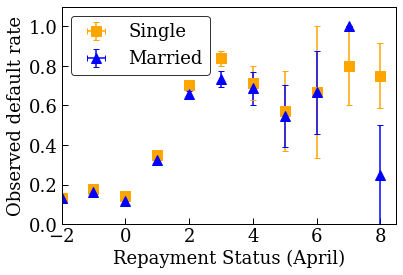

In [27]:
plot_2d_means_credit(credit_train_df, 'PAY_0', 'default',
                     'Repayment Status (April)', 'Observed default rate')

## 債務不履行率を予測する較正済み線形モデルをトレーニングする

次に、利用者がローンの債務不履行となるかどうかを予測するために、TFL の*較正済み線形モデル*をトレーニングします。利用者の 4 月の婚姻状況とローン返済の延滞月数（返済状況）を 2 つの特徴量として使用します。トレーニングラベルは、利用者がローンの債務不履行になったかどうかを示します。

まず制約を使用せずに、較正済み線形モデルをトレーニングします。次に、単調性制約を使用して較正済み線形モデルをトレーニングし、モデルの出力と精度に生じる違いを観察します。

### 債務不履行データセットの特徴量を構成するためのヘルパー関数

これらのヘルパー関数は債務不履行の事例に特化した関数です。

In [28]:
def get_input_fn_credit(input_df, num_epochs, batch_size=None):
  """Gets TF input_fn for credit default models."""
  return tf.compat.v1.estimator.inputs.pandas_input_fn(
      x=input_df[['MARRIAGE', 'PAY_0']],
      y=input_df['default'],
      num_epochs=num_epochs,
      batch_size=batch_size or len(input_df),
      shuffle=False)


def get_feature_columns_and_configs_credit(monotonicity):
  """Gets TFL feature configs for credit default models."""
  feature_columns = [
      tf.feature_column.numeric_column('MARRIAGE'),
      tf.feature_column.numeric_column('PAY_0'),
  ]
  feature_configs = [
      tfl.configs.FeatureConfig(
          name='MARRIAGE',
          lattice_size=2,
          pwl_calibration_num_keypoints=3,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
      tfl.configs.FeatureConfig(
          name='PAY_0',
          lattice_size=2,
          pwl_calibration_num_keypoints=10,
          monotonicity=monotonicity,
          pwl_calibration_always_monotonic=False),
  ]
  return feature_columns, feature_configs

### トレーニング済みモデルの出力を視覚化するためのヘルパー関数

In [29]:
def plot_predictions_credit(input_df,
                            estimator,
                            x_col,
                            x_label='Repayment Status (April)',
                            y_label='Predicted default probability'):
  predictions = get_predicted_probabilities(
      estimator=estimator, input_df=input_df, get_input_fn=get_input_fn_credit)
  new_df = input_df.copy()
  new_df.loc[:, 'predictions'] = predictions
  plot_2d_means_credit(new_df, x_col, 'predictions', x_label, y_label)

## 制約なし（非単調性）の較正済み線形モデルをトレーニングする

In [30]:
nomon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=0,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


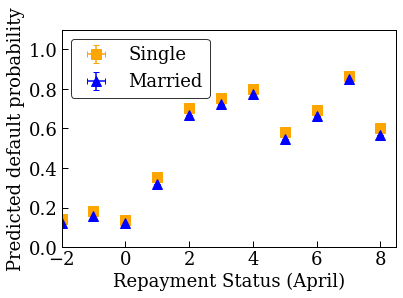

In [31]:
plot_predictions_credit(credit_train_df, nomon_linear_estimator, 'PAY_0')

## 単調な較正済み線形モデルをトレーニングする

In [32]:
mon_linear_estimator = optimize_learning_rates(
    train_df=credit_train_df,
    val_df=credit_val_df,
    test_df=credit_test_df,
    monotonicity=1,
    learning_rates=LEARNING_RATES,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    get_input_fn=get_input_fn_credit,
    get_feature_columns_and_configs=get_feature_columns_and_configs_credit)

accuracies for learning rate 0.010000: train: 0.818762, val: 0.830065, test: 0.817172


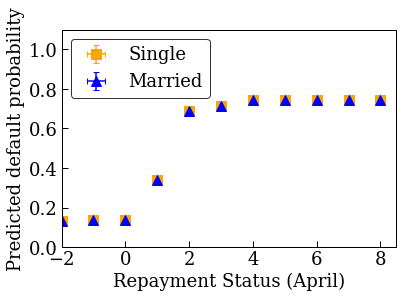

In [33]:
plot_predictions_credit(credit_train_df, mon_linear_estimator, 'PAY_0')